In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 

In [5]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

## 예비학습: `net.parameters()`의 의미 

9월27일 강의노트 중 "`net.parameters()`의 의미?"를 설명한다. 

`-` iterator, generator의 개념필요 
- https://guebin.github.io/IP2022/2022/06/06/(14주차)-6월6일.html, 클래스공부 8단계 참고 


`-` 탐구시작: 네트워크 생성 

In [13]:
net = torch.nn.Linear(in_features=1,out_features=1)
net.weight

Parameter containing:
tensor([[-0.3987]], requires_grad=True)

In [14]:
net.bias

Parameter containing:
tensor([0.2192], requires_grad=True)

`-` torch.optim.SGD? 를 확인하면 params에 대한설명에 아래와 같이 되어있음 

```
params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
```

`-` 설명을 읽어보면 params에 iterable object를 넣으라고 되어있음 (iterable object는 숨겨진 명령어로 `__iter__`를 가지고 있는 오브젝트를 의미)

In [ ]:
set(dir(net.parameters())) & {'__iter__'}

{'__iter__'}

`-` 무슨의미? 

In [ ]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.4607]], requires_grad=True)
Parameter containing:
tensor([-0.1656], requires_grad=True)


`-` 그냥 이건 이런느낌인데? 

In [ ]:
for param in [net.weight,net.bias]:
    print(param)

Parameter containing:
tensor([[0.4607]], requires_grad=True)
Parameter containing:
tensor([-0.1656], requires_grad=True)


결론: `net.parameters()`는 net오브젝트에서 학습할 파라메터를 모두 모아 리스트같은 iterable object로 만드는 함수라 이해할 수 있다. 

`-` 응용예제1

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-09-22-regression.csv") 
x=torch.tensor(df.x).float().reshape(100,1)
y=torch.tensor(df.y).float().reshape(100,1)

In [ ]:
b = torch.tensor(-5.0,requires_grad=True)
w = torch.tensor(10.0,requires_grad=True)
optimizr = torch.optim.SGD([b,w],lr=1/10) ## 이렇게 전달하면 됩니당!!

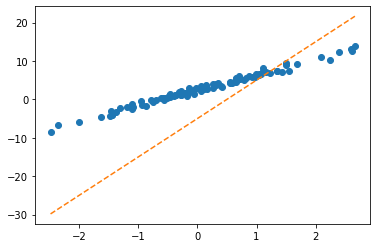

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,(w*x+b).data,'--')

In [ ]:
for epoc in range(30):
    ## step1
    yhat = b+ w*x 
    ## step2
    loss = torch.mean((y-yhat)**2)
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

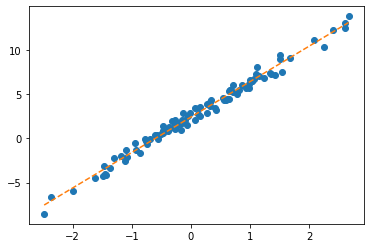

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,(w*x+b).data,'--')

`-` 응용예제2

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-09-22-regression.csv") 
x = torch.tensor(df.x).float().reshape(100,1)
y = torch.tensor(df.y).float().reshape(100,1)
X = torch.concat([torch.ones_like(x),x],axis=1)

In [ ]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)
optimizr = torch.optim.SGD([What],lr=1/10) # What은 iterable 하지 않지만 [What]은 iterable 함

In [ ]:
What

tensor([[-5.],
        [10.]], requires_grad=True)

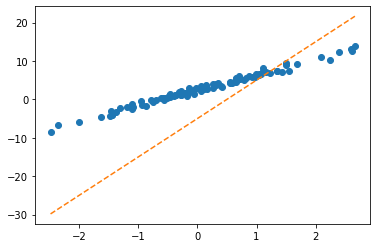

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

In [ ]:
for epoc in range(30):
    ## step1
    yhat = X@What 
    ## step2 
    loss = torch.mean((y-yhat)**2)
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

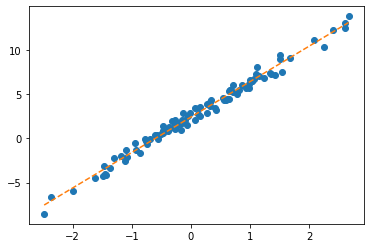

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

## Exam4: AbAcAd

In [6]:
txt = list('AbAcAd')*100

In [7]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [8]:
x = torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))

In [9]:
# 이번엔 원핫인코딩형태까지 미리 정리하자. (임베딩 레이어 안쓸예정)
x= torch.nn.functional.one_hot(x).float()
y= torch.nn.functional.one_hot(y).float()

### 실패했던 풀이: 구현1

`-` 저번시간의 실패한 풀이 

```Python
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(4,2),# 원핫인코딩은 이미 구현했으므로 이 단계는 포함하지 않는다
    torch.nn.Tanh(),
    torch.nn.Linear(2,4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
```

`-` Tanh까지만 클래스로 바꾸어서 구현 

In [11]:
class Hnet(torch.nn.Module):
    def __init__(self): # 생성자(Constructor): 객체가 생성될 때 '자동으로 호출'되는 메서드를 의미
        super().__init__() # 부모 클래스인 torch.nn.Module의 생성자 함수를 그대로 데려온다 -> super().__init__()
        self.i2h = torch.nn.Linear(4,2) # 임베딩 레이어 없으므로 선형변환 포함해야함, 원핫인코딩은 수행했음, hidden node : 2
        self.tanh = torch.nn.Tanh() 
        # tanh에 들어갈 입력의 shape이 꼭 1일 필욘 없음, hidden node가 2였으면
        # 활성화 함수에 입력 shape으로 2가 들어가도 됨
    def forward(self,x):
        hidden = self.tanh(self.i2h(x))
        return hidden

In [12]:
torch.manual_seed(43052) 
hnet = Hnet()
linr = torch.nn.Linear(2,4) 
loss_fn = torch.nn.CrossEntropyLoss() # softmax
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()))

In [13]:
for epoc in range(20):
    hidden = hnet(x) 
    output = linr(hidden)
    loss = loss_fn(output,y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

`-` linr(hnet(x)) 적합결과 <-- 이거랑

In [14]:
linr(hnet(x)) # softmax 포함 x

tensor([[-0.3589,  0.7921, -0.1970, -0.0302],
        [-0.2912,  0.8140, -0.2032,  0.0178],
        [-0.3589,  0.7921, -0.1970, -0.0302],
        ...,
        [-0.3589,  0.7921, -0.1970, -0.0302],
        [-0.1065,  0.6307, -0.0874,  0.1821],
        [-0.3589,  0.7921, -0.1970, -0.0302]], grad_fn=<AddmmBackward0>)

### 실패했던 풀이: 구현2

In [53]:
torch.manual_seed(43052) 
hnet = Hnet()
linr = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()))

In [54]:
T = len(x) # 599 = 100 * 6 - 1
for epoc in range(20): 
    ## 1~2
    loss = 0 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = hnet(xt) 
        ot = linr(ht) 
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` linr(hnet(x)) 적합결과 <-- 이거랑 동일하다

In [55]:
linr(hnet(x))

tensor([[-0.3589,  0.7921, -0.1970, -0.0302],
        [-0.2912,  0.8140, -0.2032,  0.0178],
        [-0.3589,  0.7921, -0.1970, -0.0302],
        ...,
        [-0.3589,  0.7921, -0.1970, -0.0302],
        [-0.1065,  0.6307, -0.0874,  0.1821],
        [-0.3589,  0.7921, -0.1970, -0.0302]], grad_fn=<AddmmBackward0>)

### 순환신경망의 아이디어

***${\boldsymbol h}$에 대한 이해***

> ${\boldsymbol h}$는 문자열 'abcd'들을 숫자로 바꾼 또 다른 형식의 숫자표현이라 해석할 수 있음. 
- 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할 수 있다. 
  - 원핫인코딩보다 더 (1) 액기스만 남은 느낌 + (2) 숙성된 느낌 
  - h는 "학습을 용이하게 하기 위해서 x를 적당히 선형적으로 전처리한 상태"라고 이해가능

결론: 사실 ${\boldsymbol h}$는 잘 숙성되어있는 입력정보 ${\bf X}$라고 생각할 수 있다. 

`*` 기존방식
- $\text{콩물: x} \overset{\text{숙성}}{\longrightarrow} \text{간장}$

`*` 수백년 전통의 간장맛을 유지하는 방식

- $\text{콩물}_1 : x_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1$
- $\text{콩물}_2 : x_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2$
- $\text{콩물}_3 : x_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3$

`*` 수백년 전통의 간장맛을 유지하면서 조리를 한다면? 

- $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$
- $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
- $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

`*` 알고리즘의 편의상 아래와 같이 생각해도 무방 

- $\text{콩물}_1, \text{간장}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$, 이때 $\text{간장}_0=\text{맹물}$
- $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
- $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

***아이디어***

`*` 수백년 전통의 간장맛을 유지하면서 조리하는 과정을 수식으로? 

- $\boldsymbol{x}_1, (\boldsymbol{h}_0 = \text{간장}_0 = 맹물 \to 0으로 초기화) \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_1 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_1$
- $\boldsymbol{x}_2, \boldsymbol{h}_1 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_2 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_2$
- $\boldsymbol{x}_3, \boldsymbol{h}_2 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_3 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_3$

이제 우리가 배울것은 (1) "$\text{콩물}_{t}$"와 "$\text{간장}_{t-1}$"로 "$\text{간장}_t$"를 `숙성`하는 방법 (2) "$\text{간장}_t$"로 "$\text{간장계란밥}_t$를 `조리`하는 방법이다 

즉 `숙성`담당 네트워크와 `조리`담당 네트워크를 각각 만들어 학습하면 된다. 

#### ***바뀌는 구조***

(1) $t=0$일 때

${\boldsymbol h}_0=[[0,0]]$ $\leftarrow$ $\text{간장}_0$은 맹물로 초기화

---

(2) $t=1$일 때

${\boldsymbol h}_1= \tanh({\boldsymbol x}_1{\bf W}_{ih}+{\boldsymbol h}_0{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
- tanh에 들어갈 입력값은 output이 2인 것이 들어가야 한다
- ${\boldsymbol x}_1$: (1,4) $\to$ 원핫인코딩된 형태
- ${\bf W}_{ih}$: (4,2) $\to$ output이 2가 되어야 하니까
- ${\boldsymbol h}_0$: (1,2) $\to$ **맹물..........$\to$ 씨간장의 시초 역할
- ${\bf W}_{hh}$: (2,2) $\to$ output이 2가 되어야 하니까.. 그리고 다 더하려면 차원계속 유지해줘야 함
- ${\boldsymbol b}_{ih}$: (1,2)
- ${\boldsymbol b}_{hh}$: (1,2)

${\boldsymbol o}_1= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$ $\to$ 두번째 선형변환 
- shape이 4가 될 것이다. 

$\hat{\boldsymbol y}_1 = \text{soft}({\boldsymbol o}_1)$

---

일반화된 알고리즘 

***(ver1)***

init $\boldsymbol{h}_0$ 

for $t$ in $1:T$ 

- ${\boldsymbol h}_t= \tanh({\boldsymbol x}_t{\bf W}_{ih}+{\boldsymbol h}_{t-1}{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
- ${\boldsymbol o}_t= {\bf W}_{ho}{\boldsymbol h}_t+{\boldsymbol b}_{ho}$
- $\hat{\boldsymbol y}_t = \text{soft}({\boldsymbol o}_t)$
    

***(ver2)***

```Python 
init hidden

for t in 1:T 
    hidden = tanh(linr(x)+linr(hidden))
    output = linr(hidden)
    yt_hat = soft(output)
```    

---

***전체알고리즘은 대충 아래와 같은 형식으로 구현될 수 있음***

```Python 
### 
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        linr1 = torch.nn.Linear(?,?) 
        linr2 = torch.nn.Linear(?,?) # 과거의 씨간장 넣어주는 역할!!
        tanh = torch.nn.Tanh()
    def forward(self,x,hidden):
        hidden = tanh(lrnr1(x)+lrnr2(hidden))
        return hidden

init ht
rnncell = rNNCell()

for t in 1:T 
    xt, yt = x[[t]], y[[t]] 
    ht = rnncell(xt, ht)
    ot = linr(ht) 
    loss = loss + loss_fn(ot, yt)

```    

### 순환신경망 구현1 -- 성공 

`(1)` 숙성담당 네트워크

In [60]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2) # hidden node : 2
        self.h2h = torch.nn.Linear(2,2) 
        self.tanh = torch.nn.Tanh()
    def forward(self,x,hidden):
        hidden = self.tanh(self.i2h(x)+self.h2h(hidden))
        return hidden

In [61]:
torch.manual_seed(43052)
rnncell = rNNCell() # 숙성담당 네트워크 

`(2)` 조리담당 네트워크

In [62]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수, 옵티마이저 설계 

In [63]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습 (6분정도 걸림)

In [64]:
T = len(x) 
for epoc in range(5000): 
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) # 맹물...! size 유의!
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht) 
        ot = cook(ht) # 조리
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [65]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 씨간장 role... hidden의 시초 역할\
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]]) 

In [66]:
yhat = soft(cook(hidden))
yhat

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4711e-03, 6.1182e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

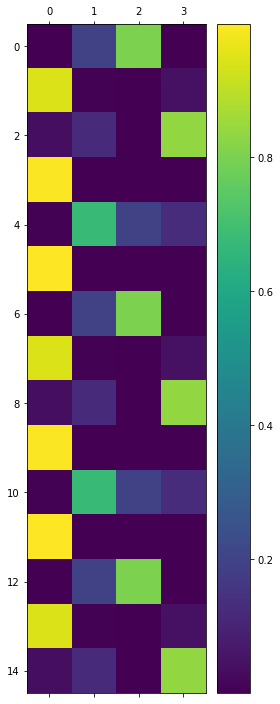

In [82]:
plt.matshow(yhat.data[-15:]) # 뒤에서부터 15개 뽑음
plt.colorbar()
# A를 가장 잘 학습

- 특징: yhat[:15], yhat[:-15] 의 적합결과가 다르다
  - 왜? 간장계란밥은 간장이 중요한데, 간장은 시간이 갈수록 맛있어지니까..

### 순환신경망 구현2 (with RNNCell) -- 성공 

`(1)` 숙성네트워크

선언

In [68]:
rnncell = torch.nn.RNNCell(4,2)

In [ ]:
torch.manual_seed(43052)
_rnncell = rNNCell() # 이건 위에서 clss로 선언했었던 순환신경망

In [70]:
# 가중치초기화 (순환신경망 구현1과 동일하도록)
rnncell.weight_ih.data = _rnncell.i2h.weight.data 
rnncell.weight_hh.data = _rnncell.h2h.weight.data 
rnncell.bias_hh.data = _rnncell.h2h.bias.data 
rnncell.bias_ih.data = _rnncell.i2h.bias.data 

`(2)` 조리담당 네트워크

In [71]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수, 옵티마이저 설계 

In [72]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습 (6분정도 걸림)

In [73]:
T = len(x) 
for epoc in range(5000): 
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht) 
        ot = cook(ht) 
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [74]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]]) 

In [75]:
yhat = soft(cook(hidden))
yhat

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4711e-03, 6.1182e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

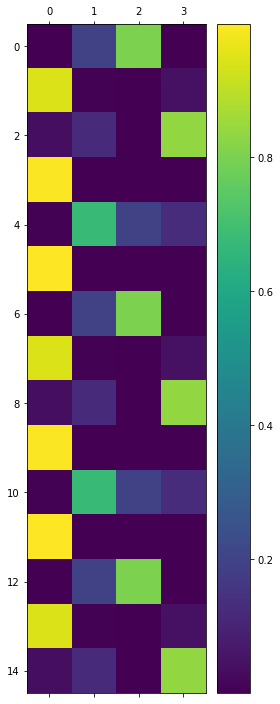

In [83]:
plt.matshow(yhat.data[-15:])
plt.colorbar()

----

## 숙제 

아래와 같은 자료가 있다고 가정하자. 

In [84]:
x = torch.rand([1000,1])*2-1
y = 3.14 + 6.28*x + torch.randn([1000,1]) 

아래의 모형을 가정하고 $\alpha_0,\alpha_1,\beta_0,\beta_1$을 파이토치를 이용하여 추정하고자한다.

- $y_i = \alpha_0+\beta_0+ \beta_1x_i + \alpha_1x_i + \epsilon_i \quad \epsilon_i \sim N(0,\sigma^2)$ 


아래는 이를 수행하기 위한 코드이다. ???를 적절히 채워서 코드를 완성하라. 

In [86]:
alpha0 = torch.tensor([0.5], requires_grad=True)
alpha1 = torch.tensor([[0.5]], requires_grad=True)
beta0 = torch.tensor([0.7], requires_grad=True)
beta1 = torch.tensor([[0.7]], requires_grad=True)

In [87]:
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD([alpha0,beta0,alpha1,beta1], lr=1/10)

In [88]:
for epoc in range(30):
    ## 1
    yhat = alpha0 + beta0 + alpha1*x + beta1*x 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [89]:
print(alpha0+beta0)

tensor([3.0865], grad_fn=<AddBackward0>)


- 3.14 근처

In [90]:
print(alpha1+beta1)

tensor([[6.2065]], grad_fn=<AddBackward0>)


- 6.28 근처

---

---

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

## Exam4: AbAcAd (3)

In [16]:
txt = list('AbAcAd')*100

In [17]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [18]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))).float()

### 순환신경망 구현2 (with RNNCell, hidden node 2) -- 성공 (복습)

`(1)` 숙성네트워크

In [19]:
torch.manual_seed(43052)
rnncell = torch.nn.RNNCell(4,2) # x:(n,4) , hidden:(n,2) 

`(2)` 조리네트워크

In [20]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 숙성된 2차원의 단어를 다시 4차원으로 바꿔줘야지 나중에 softmax 취할 수 있음

`(3)` 손실함수와 옵티마이저 

In [21]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습

In [22]:
T = len(x) 
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) # 맹물
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [23]:
hidden = torch.zeros(len(x),2) 

In [24]:
# t=0 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
# t=1~T 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [30]:
yhat = soft(cook(hidden))
yhat

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7702e-02, 1.3384e-02],
        [2.0031e-02, 1.0660e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

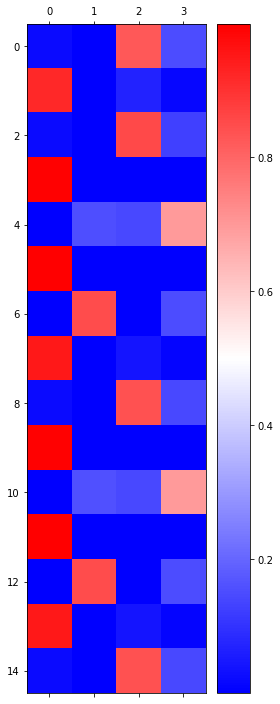

In [33]:
plt.matshow(yhat[:15].data,cmap='bwr')
plt.colorbar()
# 처음부터 15개

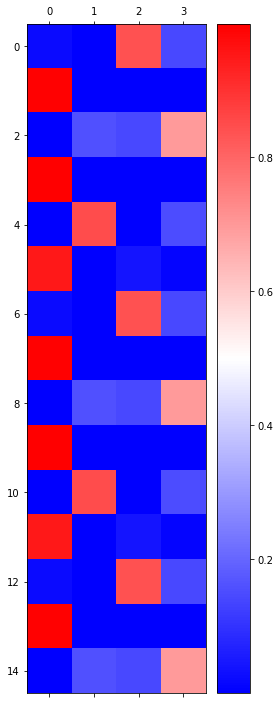

In [34]:
plt.matshow(yhat[-15:].data,cmap='bwr')
plt.colorbar()
# 마지막 15개

### 순환신경망 구현3 (with RNN, hidden node 2) -- 성공 

(예비학습)

`-` 네트워크학습이후 yhat을 구하려면 번거로웠음 

```Python
hidden = torch.zeros(T,2) 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])
yhat = soft(cook(hidden))
```

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

In [35]:
rnn = torch.nn.RNN(4,2)

In [36]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 
  - batch 형태로 반환됨을 알 수 있다. 

In [37]:
rnn(x,_water) 
# 이거랑(두번째 tuple 원소는 제외하고)
# 지금은 rnncell에서 학습한 가중치와 편향들을 rnn에 넣어줘서 
# rnn은 학습과정을 거치지 않았지만 학습이 된 것처럼 작동가능

(tensor([[-0.9912, -0.9117],
         [ 0.0698, -1.0000],
         [-0.9927, -0.9682],
         ...,
         [-0.9935, -0.9315],
         [ 0.5777, -1.0000],
         [-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>))

In [39]:
hidden # 이거랑 동일

tensor([[-0.9912, -0.9117],
        [ 0.0698, -1.0000],
        [-0.9927, -0.9682],
        ...,
        [-0.9935, -0.9315],
        [ 0.5777, -1.0000],
        [-0.9960, -0.0109]], grad_fn=<IndexPutBackward0>)

In [ ]:
soft(cook(rnn(x,_water)[0]))

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7702e-02, 1.3384e-02],
        [2.0031e-02, 1.0660e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

> ***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

In [ ]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [ ]:
torch.manual_seed(43052)
_rnncell = torch.nn.RNNCell(4,2)

In [ ]:
rnn.weight_hh_l0.data = _rnncell.weight_hh.data 
rnn.weight_ih_l0.data = _rnncell.weight_ih.data
rnn.bias_hh_l0.data = _rnncell.bias_hh.data
rnn.bias_ih_l0.data = _rnncell.bias_ih.data

`(2)` 조리네트워크

In [ ]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수와 옵티마이저

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
_water = torch.zeros(1,2) 
for epoc in range(5000):
    ## 1 
    hidden,hT = rnn(x,_water)
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

- 애초에 torch.nn.RNNCell(4,2)이 batch 형태로 반환하기 때문에 시각화할 떄 yhat을 하나하나 쌓을 필요가 없음
- 아! 그리고 이렇게 batch 형태로 5000번 학습하면 RNNCell이 더 유용한 거 아니야?라고 생각할 수 있는데
  - 그럴까봐 다른 학습 과정에서는 이중 포문 구조로 설정하여 batch와 유사하게 학습이 가능하도록 모형을 구현했음
> 그런데 RNNCell이 배치학습이긴 하지만 이것도 포문이 중첩이 된 것으로 생각 가능하다

In [ ]:
yhat = soft(output)

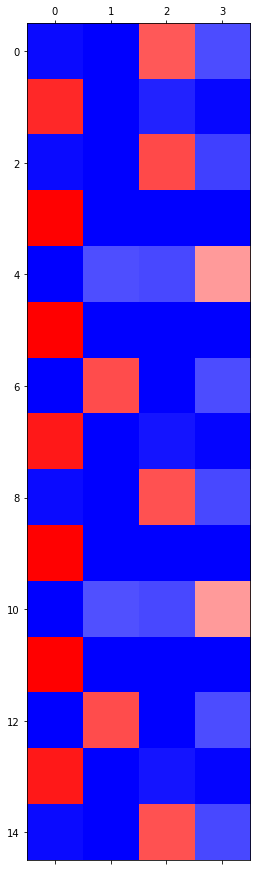

In [ ]:
plt.matshow(yhat.data[:15],cmap='bwr')

- 처음은 좀 틀렸음 ㅎㅎ

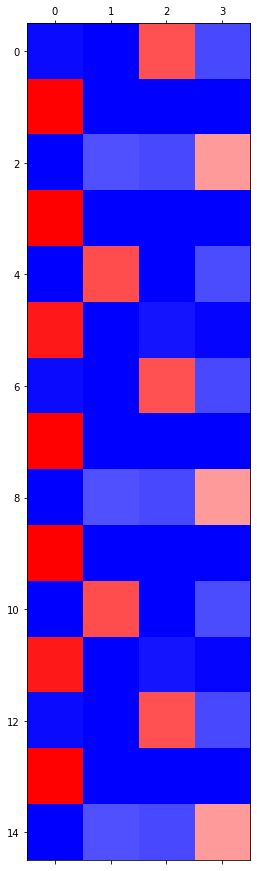

In [ ]:
plt.matshow(yhat.data[-15:],cmap='bwr')

- 뒤에는 잘맞음 

**실전팁: `_water` 대신에 `hT`를 대입 (사실 큰 차이는 없음)**

In [ ]:
rnn(x[:6],_water),rnn(x[:6],hT)

((tensor([[-0.9912, -0.9117],
          [ 0.0698, -1.0000],
          [-0.9927, -0.9682],
          [ 0.5761, -1.0000],
          [-0.9960, -0.0173],
          [ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>)),
 (tensor([[-0.9713, -1.0000],
          [ 0.0535, -1.0000],
          [-0.9925, -0.9720],
          [ 0.5759, -1.0000],
          [-0.9960, -0.0180],
          [ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>)))

`(6)` 시각화2: hidden, yhat

In [ ]:
combinded = torch.concat([hidden,yhat],axis=1)

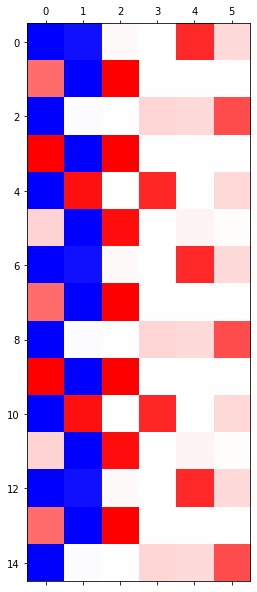

In [ ]:
plt.matshow(combinded[-15:].data,cmap='bwr')

- 히든노드의 해석이 어려움. 

### 순환신경망 구현4 (with RNN, hidden node 3) -- 성공 

`(1)` 숙성네트워크~ `(2)` 조리네트워크

In [ ]:
torch.manual_seed(2) #1 
rnn = torch.nn.RNN(4,3) #hidden node : 3
cook = torch.nn.Linear(3,4) 

`(3)` 손실함수와 옵티마이저

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
_water = torch.zeros(1,3) 
for epoc in range(5000):
    ## 1
    hidden,hT = rnn(x,_water) 
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [ ]:
yhat = soft(output)

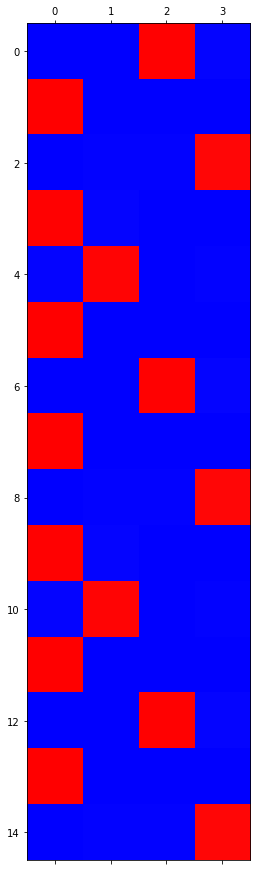

In [ ]:
plt.matshow(yhat[-15:].data,cmap='bwr')

`(6)` 시각화2: hidden(node : 3), yhat

In [ ]:
combinded = torch.concat([hidden,yhat],axis=1)

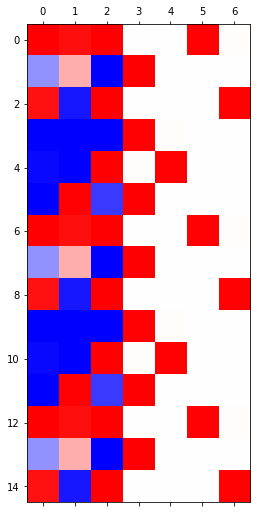

In [ ]:
plt.matshow(combinded[-15:].data,cmap='bwr')

> ### 첫 번째, 두 번째 히든노드 $\to$ bcd를 구분 
> ### 세 번째 히든노드 $\to$ 대소문자를 구분

## HW: hello 예제

아래와 같이 hello가 반복되는 자료가 있다고 하자. 

In [8]:
txt = list('hello')*100

txt_x = txt[:-1]
txt_y = txt[1:]

x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'h':0,'e':1,'l':2,'o':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'h':0,'e':1,'l':2,'o':3}))).float()

In [9]:
rnn = torch.nn.RNN(4,3) # hidden node : 3
cook = torch.nn.Linear(3,4)

`(3)` 손실함수와 옵티마이저

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [11]:
_water = torch.zeros(1,3) 
for epoc in range(5000):
    ## 1
    hidden,hT = rnn(x,_water) # hT는 사실 사용하지 않으므로 그냥 under bar처리해도 됨
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [12]:
yhat = soft(output)

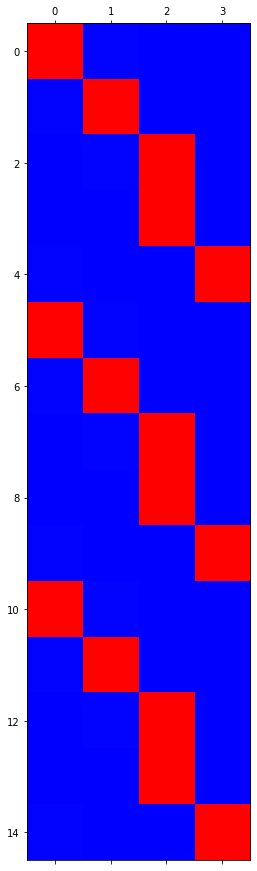

In [13]:
plt.matshow(yhat[-15:].data,cmap='bwr')

`(6)` 시각화2: hidden, yhat

In [14]:
combinded = torch.concat([hidden,yhat],axis=1)

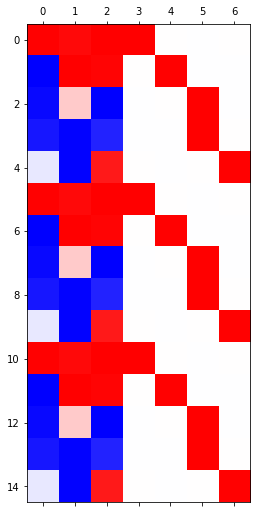

In [15]:
plt.matshow(combinded[-15:].data,cmap='bwr')